In [45]:
# Import dependencies for XGBoost
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# Load the data
data = pd.read_csv('VIX_data.csv',index_col="Date")
data.index = pd.to_datetime(data.index)
data_clean = data
data_clean.fillna(data_clean.mean(), inplace=True)

In [47]:
# Clean the data
indexes = ['DJI', 'NASDAQ', 'GOLD', 'OIL', 'FTSE', 'NIKKEI', 'RUSSELL2000']
for index in indexes:
    data_clean[index+' High Minus Low'] = data_clean[index+' High'] - data_clean[index+' Low']
# Remove all open and close prices
data_clean = data_clean.drop(columns=['DJI Open', 'DJI Close', 'NASDAQ Open', 'NASDAQ Close', 'GOLD Open', 'GOLD Close', 'OIL Open', 'OIL Close', 'FTSE Open', 'FTSE Close', 'NIKKEI Open', 'NIKKEI Close', 'RUSSELL2000 Open', 'RUSSELL2000 Close'])

In [48]:
explanatory_vars = data_clean.drop(columns=['VIX'])
y_entire = data_clean['VIX']

In [49]:
# Split the data into training and testing sets first
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(explanatory_vars, y_entire, test_size=0.1, shuffle=False)

In [50]:
all_feature_names = list(X_train_full.columns)
# Initialize variables
best_features = []
best_rmse = float('inf')
remaining_features = all_feature_names.copy()

In [51]:
x_train, x_opt, y_train, y_opt = train_test_split(X_train_full, y_train_full, test_size=0.1, shuffle=False)

In [52]:
from sklearn.feature_selection import RFE

# Initialize the XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=3, random_state=42)

# Perform Recursive Feature Elimination (RFE)
rfe = RFE(estimator=xg_reg, n_features_to_select=10, step=1)  # Select top 10 features

# Fit RFE on the training data
rfe.fit(x_train, y_train)

# Get the selected feature names
selected_features = x_train.columns[rfe.support_]

# Evaluate the model with the selected features
X_train_selected = rfe.transform(x_train)
X_test_selected = rfe.transform(x_opt)

# Retrain the model using only the selected features
xg_reg.fit(X_train_selected, y_train)
y_pred_selected = xg_reg.predict(X_test_selected)

# Calculate the new evaluation metrics
mse_selected = root_mean_squared_error(y_opt, y_pred_selected)
r2_selected = r2_score(y_opt, y_pred_selected)

selected_features, mse_selected, r2_selected


(Index(['Initial Claims', 'SP500 Volume', 'DJI Low', 'DJI Volume',
        'FTSE Adj Close', 'DJI High Minus Low', 'NASDAQ High Minus Low',
        'FTSE High Minus Low', 'NIKKEI High Minus Low',
        'RUSSELL2000 High Minus Low'],
       dtype='object'),
 3.3122694381139524,
 0.0038888746867961066)

In [53]:
X_train, X_opt, y_train, y_opt = train_test_split(X_train_full[selected_features], y_train_full, test_size=0.111111, shuffle=False)

In [54]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'max_depth': [3, 5, 7, None],          # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2, None],  # Step size shrinkage
    'subsample': [0.8, 1.0, None],         # Fraction of samples used for fitting
    'colsample_bytree': [0.8, 1.0, None]   # Fraction of features used per tree
}

# Initialize RandomForestRegressor and GridSearchCV
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, 
                           scoring='neg_root_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract the best model and parameters
best_xg = grid_search.best_estimator_
optimized_params = grid_search.best_params_

# Make predictions and calculate performance metrics
y_pred = best_xg.predict(X_opt)
rmse = root_mean_squared_error(y_opt, y_pred)
mae = mean_absolute_error(y_opt, y_pred)
r2 = r2_score(y_opt, y_pred)

print("Optimized Parameters:", optimized_params)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


Optimized Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
RMSE: 3.3530, MAE: 2.9903, R²: 0.4628


In [55]:
X = X_train_full[selected_features]
y = y_train_full

In [56]:
best_xg.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [57]:
y_pred = best_xg.predict(X_test_full[selected_features])
# Calculate RMSE
rmse = root_mean_squared_error(y_test_full, y_pred)
# Calculate MAPE
mape = np.mean(np.abs((y_test_full - y_pred) / y_test_full)) * 100
# Calculate R²
r2 = r2_score(y_test_full, y_pred)
# Calculate Directional Accuracy
directional_accuracy = np.mean(np.sign(y_test_full.diff().dropna()) == np.sign(pd.Series(y_pred, index=y_test_full.index).diff().dropna())) * 100

print(f"RMSE: {rmse:.4f}, MAPE: {mape:.4f}%, R²: {r2:.4f}, Directional Accuracy: {directional_accuracy:.4f}%")

RMSE: 3.4852, MAPE: 22.3953%, R²: -2.2391, Directional Accuracy: 54.5455%


In [58]:
feature_importances = best_xg.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

In [59]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

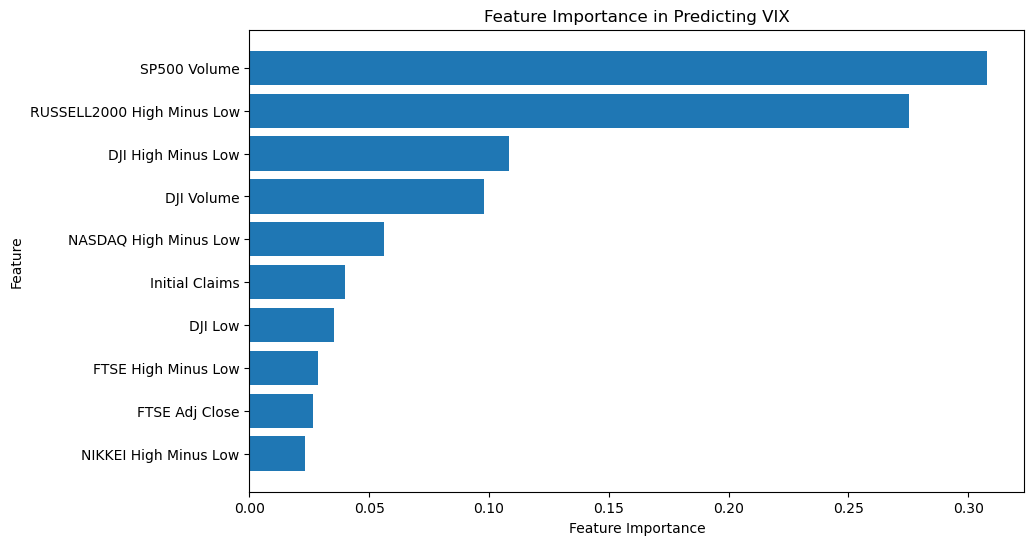

In [60]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting VIX')
plt.gca().invert_yaxis()
plt.show()

In [61]:
# Add dates back to predictions
y_pred_df = pd.DataFrame(y_pred, index=X_test_full.index, columns=['VIX Prediction'])
y_test_df = pd.DataFrame(y_test_full, index=X_test_full.index, columns=['VIX'])

In [62]:
y_pred_df

,VIX Prediction
Date,
2023-10-01,19.076687
2023-11-01,18.416889
2023-12-01,17.687477
2024-01-01,16.321989
2024-02-01,14.711444
2024-03-01,16.214851
2024-04-01,18.053873
2024-05-01,18.744600
2024-06-01,16.493828


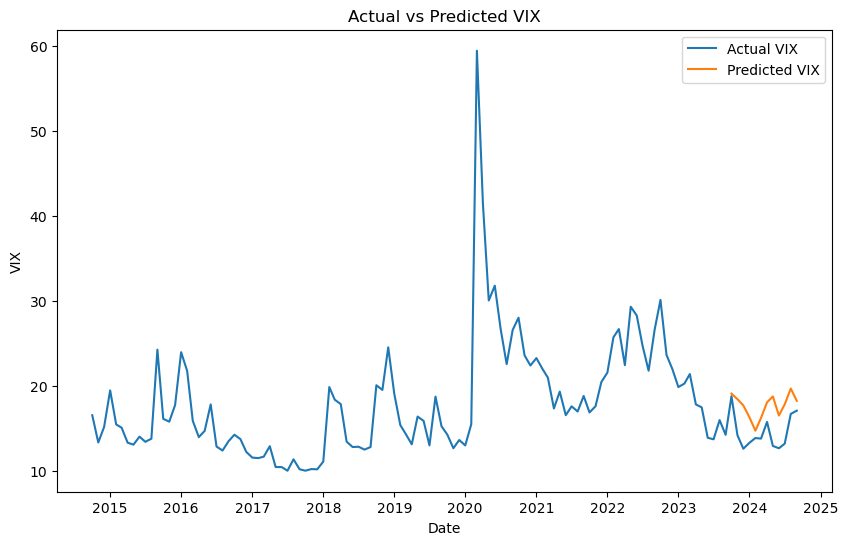

In [63]:
# Plot the actual VIX for the entire time series and the predicted VIX for the test set
plt.figure(figsize=(10, 6))
plt.title('Actual vs Predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.plot(y_entire, label='Actual VIX')
plt.plot(y_pred_df.index, y_pred_df['VIX Prediction'], label='Predicted VIX')
plt.legend()
plt.show()



In [64]:
# Combine Data Frame of Predictions and Actual VIX
combined = pd.concat([y_test_df, y_pred_df], axis=1)
combined

,VIX,VIX Prediction
Date,,
2023-10-01,18.775,19.076687
2023-11-01,14.165,18.416889
2023-12-01,12.595,17.687477
2024-01-01,13.280,16.321989
2024-02-01,13.850,14.711444
2024-03-01,13.785,16.214851
2024-04-01,15.745,18.053873
2024-05-01,12.920,18.744600
2024-06-01,12.645,16.493828
